In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd

In [14]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [16]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)


# reflect the tables

In [18]:
# We can view all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()


['measurement', 'station']

In [19]:
# Using the inspector to print the column names within the 'dow' table and its types
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [20]:
# Save references to each table
# Print all of the classes mapped to the Base
Measurement = Base.classes.measurement
Station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
# Create a session
session = Session(engine)


# Exploratory Climate Analysis

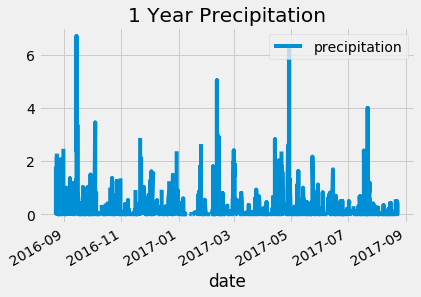

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(max_date)
#this comes w/ 2 answer just need the first part of the index
max_date = max_date[0]
#print(max_date) - now it's just 2017-08-23
year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(query,columns=['date', 'precipitation'])
# Change datatype from element to datetime object on Pandas. I admit my tutor helped me here. 
precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y-%m-%d')
# Set index to date
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title="1 Year Precipitation")
plt.legend(loc='upper right')
plt.savefig("Images/Precipitation.png")
plt.show()


In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
print(f"There are: {station_count} counted stations in this data set ")




There are: 9 counted stations in this data set 


In [25]:
# What are the most active stations?
# List the stations and the counts in descending order. I had no idea func.count goes before!!!
station_activity_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"station_activity_count")
print(station_activity_count)

# Find the most active station 
most_active_station=station_activity_count[0][0]
print(f"Most Active Station: {most_active_station}")




station_activity_count
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
Most Active Station: USC00519281


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
all_the_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
#print(all_the_temps)
#information is inside an array. 
print(f"Most Active Station Temperatures")
print(f"Low: {all_the_temps[0][0]} High: {all_the_temps[0][1]} Average: {round(all_the_temps[0][2], 1)}")


Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


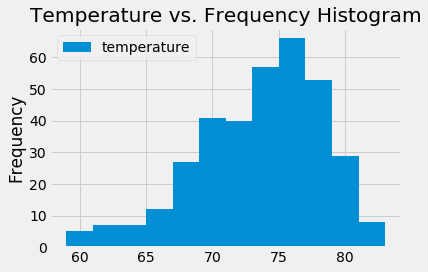

In [27]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])
# one bin per month
temperature_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.tight_layout()
plt.savefig("Images/TemperaturevsFrequency.png")
plt.show()

## Bonus Challenge Assignment

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# function usage example
bdaytrip = calc_temps('2017-03-05','2017-03-12')
bdaytrip

[(62.0, 70.34042553191489, 82.0)]

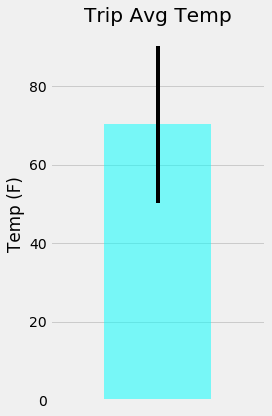

In [30]:
#Turn the above array into a data frame
bdaytrip_temp_df = pd.DataFrame(bdaytrip, columns=['tmin', 'tavg', 'tmax'])
bdaytrip_temp_df
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (year)
bdaytrip_temp_df.plot.bar(y='tavg', yerr=(bdaytrip_temp_df['tmax'] - bdaytrip_temp_df['tmin']), title='Trip Avg Temp', color='aqua', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()


In [31]:
#double checking my answers.
bdaytrip_temp_df.describe()

,tmin,tavg,tmax
count,1.0,1.000000,1.0
mean,62.0,70.340426,82.0
std,NaN,NaN,NaN
min,62.0,70.340426,82.0
25%,62.0,70.340426,82.0
50%,62.0,70.340426,82.0
75%,62.0,70.340426,82.0
max,62.0,70.340426,82.0


In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
#THis is when i'm going
Startdate = '2017-03-05'
Enddate ='2017-03-12'
# I need to get all the dates including my start and end. 
dates = session.query(Measurement.date).filter(Measurement.date >= Startdate).filter(Measurement.date <= Enddate).group_by(Measurement.date).all()
#print(dates) There are all the dates in there.
# i ahve all the dates now i have to query the data w/ the dates i want. 

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


def precip(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precip(Startdate,Enddate))




[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.41), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.35), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.35), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]


In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [45]:
# calculate the daily normals for your trip
#Startdate = '2017-03-05'
#Enddate ='2017-03-12'
#ok I can figure out date time i'm gonna take a short cut
bday_trip_dates = ["03-05","03-06","03-07","03-08","03-09","03-10","03-11","03-12"]
# push each tuple of calculations into a list called `normals`

mins = []
avgs = []
maxs = []


# Loop through the list of %m-%d strings and calculate the normals for each date
for day in bday_trip_dates:
    daily_normals(day)
    mins.append(daily_normals(day)[0][0])
    avgs.append(daily_normals(day)[0][1])
    maxs.append(daily_normals(day)[0][2])
    
print(bday_trip_dates)    
print(mins)    
print(avgs)    
print(maxs)
    

['03-05', '03-06', '03-07', '03-08', '03-09', '03-10', '03-11', '03-12']
[60.0, 60.0, 60.0, 59.0, 57.0, 57.0, 60.0, 62.0]
[67.89090909090909, 69.20338983050847, 69.17241379310344, 68.72413793103448, 68.56140350877193, 69.12280701754386, 69.89285714285714, 69.88888888888889]
[76.0, 76.0, 78.0, 78.0, 75.0, 75.0, 82.0, 80.0]


In [50]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Trip_df = pd.DataFrame({
    'Trip Dates':bday_trip_dates,
    'Min':mins,
    'Normal':avgs,
    'Max':maxs
})
Trip_df

,Trip Dates,Min,Normal,Max
0,03-05,60.0,67.890909,76.0
1,03-06,60.0,69.203390,76.0
2,03-07,60.0,69.172414,78.0
3,03-08,59.0,68.724138,78.0
4,03-09,57.0,68.561404,75.0
5,03-10,57.0,69.122807,75.0
6,03-11,60.0,69.892857,82.0
7,03-12,62.0,69.888889,80.0


<function matplotlib.pyplot.show(*args, **kw)>

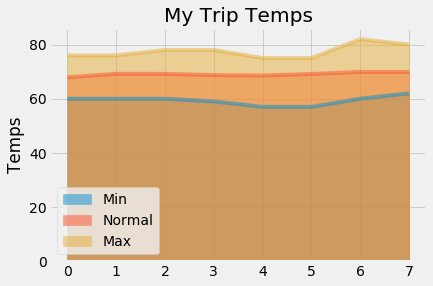

In [54]:
# Plot the daily normals as an area plot with `stacked=False`
plot = Trip_df.plot.area(stacked=False)
plt.title('My Trip Temps')
plt.ylabel('Temps')
plt.savefig("Images/TripStacked.png")
plt.show

In [ ]:
# Temperature Analysis I
# Hawaii is reputed to enjoy mild weather all year. 
#Is there a meaningful difference between the temperature in, for example, June and December?
# You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.
# Identify the average temperature in June at all stations across all available years in the dataset. 
#Do the same for December temperature.
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?

In [55]:
hawaii_measurements=pd.read_csv('Resources/hawaii_measurements.csv')
hawaii_stations=pd.read_csv('Resources/hawaii_stations.csv')
hawaii_measurements.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [58]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
#Do the same for December temperature.

#average temp use groupby, but i had difficulty w/ dates this str.slice worked to just cut it on the month column
avg_june_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='06'].groupby(hawaii_measurements['station']).mean()
avg_dec_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='12'].groupby(hawaii_measurements['station']).mean()

print(avg_june_temp)
print(avg_dec_temp)


                 prcp       tobs
station                         
USC00511918  0.015157  74.139394
USC00513117  0.118248  74.050847
USC00514830  0.114192  76.005376
USC00516128  0.495748  71.937220
USC00517948  0.057975  76.655405
USC00518838  0.094615  73.394737
USC00519281  0.151525  73.271186
USC00519397  0.022661  77.559322
USC00519523  0.050044  76.668103
                 prcp       tobs
station                         
USC00511918  0.138146  69.684211
USC00513117  0.203241  71.069444
USC00514830  0.154966  73.224719
USC00516128  0.507005  69.291262
USC00517948  0.152727  71.834862
USC00518838  0.638182  72.421053
USC00519281  0.244931  69.903226
USC00519397  0.075314  71.109524
USC00519523  0.162010  72.433333


In [57]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?
import scipy.stats as stats
stats.ttest_ind(avg_june_temp['tobs'], avg_dec_temp['tobs'], equal_var=False)


Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)

In [ ]:
#Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)

#using the unpaired test because June is different than Decemeber. They are independent of each other. 
#The pvalue is under .05
#The null hypothesis is that the two population means are the same; 
#in other words, that their difference is equal to 0. 
#I reject the null hypothesis the months are different. 
